In [1]:
import qubx

%qubxd

%load_ext autoreload
%autoreload 2

from typing import cast
import numpy as np
import pandas as pd
import asyncio
from pathlib import Path
from qubx.core.lookups import lookup
from qubx.utils.runner.accounts import AccountConfigurationManager
from qubx.connectors.ccxt.factory import get_ccxt_exchange
from qubx import logger, QubxLogConfig
from qubx.core.interfaces import IStrategy, IStrategyContext, BaseErrorEvent, IStrategyInitializer
from qubx.utils.runner.runner import run_strategy, StrategyConfig, AccountConfigurationManager, ExchangeConfig, LoggingConfig
from qubx.utils.runner.configs import LiveConfig, ReaderConfig
from qubx.core.basics import DataType, MarketEvent
from qubx.utils.charting.lookinglass import LookingGlass

QubxLogConfig.set_log_level("INFO")


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2025, ver. 0.6.68
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


## 1.0 Define simple strategy that does nothing

Just subscribes to OHLC[1h], orderbook (top 20 levels).

In [2]:
class TestStrategy(IStrategy):

    def on_init(self, initializer: IStrategyInitializer):
        initializer.set_base_subscription(DataType.OHLC["1h"])
        initializer.subscribe(DataType.ORDERBOOK[0.0, 20])
        initializer.set_subscription_warmup({
            DataType.OHLC["1h"]: "1d"
        })
    
    def on_market_data(self, ctx: IStrategyContext, data: MarketEvent):
        pass

    def on_error(self, ctx: IStrategyContext, error: BaseErrorEvent) -> None:
        logger.error(f"Error: {error}")

    def on_stop(self, ctx: IStrategyContext):
        logger.info("Stopping test strategy")

## 2.0 Run strategy without blocking

In [3]:
ctx = run_strategy(
    config=StrategyConfig(
        name="TestStrategy",
        strategy=TestStrategy,
        aux=ReaderConfig(reader="ccxt", args={"exchanges": ["HYPERLIQUID.F"], "max_history": "10d"}),
        live=LiveConfig(
            exchanges={
                "HYPERLIQUID.F": ExchangeConfig(
                    connector="ccxt",
                    universe=["BTCUSDC", "ETHUSDC"],
                )
            },
            logging=LoggingConfig(
                logger="InMemoryLogsWriter",
                position_interval="10s",
                portfolio_interval="1m",
                heartbeat_interval="10m",
            )
        )
    ),
    account_manager=AccountConfigurationManager(),
    paper=True,
    blocking=False,
)

2025-08-07 14:18:53.109 [ℹ️] HYPERLIQUID.F Initialized
2025-08-07 14:18:53.110 [ℹ️] - Strategy: TestStrategy
- Mode: paper
- Parameters: {}
2025-08-07 14:18:53.117 [ℹ️] HYPERLIQUID.F Starting subscription warmup for 2 items
2025-08-07 14:18:58.879 [ℹ️] HYPERLIQUID.F Warmup completed successfully
2025-08-07 14:18:58.880 [ℹ️] [HYPERLIQUID.F] Setting up individual streams for 2 instruments
2025-08-07 14:18:58.881 [ℹ️] [HYPERLIQUID.F] Setting up individual streams for 2 instruments
2025-08-07 14:18:58.882 [ℹ️] HYPERLIQUID.F Listening to ETHUSDC:orderbook(0.0, 20)
2025-08-07 14:18:58.883 [ℹ️] HYPERLIQUID.F Listening to BTCUSDC:orderbook(0.0, 20)
2025-08-07 14:18:58.884 [ℹ️] [StrategyContext] :: Start processing market data
2025-08-07 14:18:58.885 [ℹ️] [StrategyContext] :: strategy is started in thread
2025-08-07 14:18:58.896 [ℹ️] HYPERLIQUID.F Listening to ETHUSDC:ohlc(1h)
2025-08-07 14:18:58.938 [ℹ️] HYPERLIQUID.F Listening to BTCUSDC:ohlc(1h)


2025-08-07 14:18:59.282 [ℹ️] Waiting for all instruments (0/2 ready). Missing: ['ETHUSDC', 'BTCUSDC']. Will start with partial data in 60s
2025-08-07 14:18:59.759 [ℹ️] Heartbeat at 2025-08-07T14:10:00
2025-08-07 14:19:02.730 [ℹ️] All 2 instruments have data - strategy ready to start
2025-08-07 14:19:03.968 [ℹ️] HYPERLIQUID.F Starting subscription warmup for 5 items
2025-08-07 14:19:10.375 [ℹ️] HYPERLIQUID.F Warmup completed successfully
2025-08-07 14:19:10.377 [ℹ️] [HYPERLIQUID.F] Setting up individual streams for 7 instruments
2025-08-07 14:19:10.379 [ℹ️] [HYPERLIQUID.F] Setting up individual streams for 7 instruments
2025-08-07 14:19:10.380 [ℹ️] HYPERLIQUID.F Listening to SOLUSDC:orderbook(0.0, 20)
2025-08-07 14:19:10.383 [ℹ️] HYPERLIQUID.F Listening to LINKUSDC:orderbook(0.0, 20)
2025-08-07 14:19:10.383 [ℹ️] HYPERLIQUID.F Listening to DOGEUSDC:orderbook(0.0, 20)
2025-08-07 14:19:10.390 [ℹ️] HYPERLIQUID.F Listening to ADAUSDC:orderbook(0.0, 20)
2025-08-07 14:19:10.398 [ℹ️] HYPERLIQUI

Add more instruments to universe

In [4]:
add_symbols = ["BTCUSDC", "ETHUSDC", "XRPUSDC", "SOLUSDC", "DOGEUSDC", "ADAUSDC", "LINKUSDC"]
add_instruments = [ctx.query_instrument(symbol) for symbol in add_symbols]
ctx.set_universe(add_instruments)

Subscribe to funding rates from all hyperliquid instruments with 1min polling interval.

In [5]:
ctx.subscribe(DataType.FUNDING_RATE["all", 1])

Plot hourly price over the last day

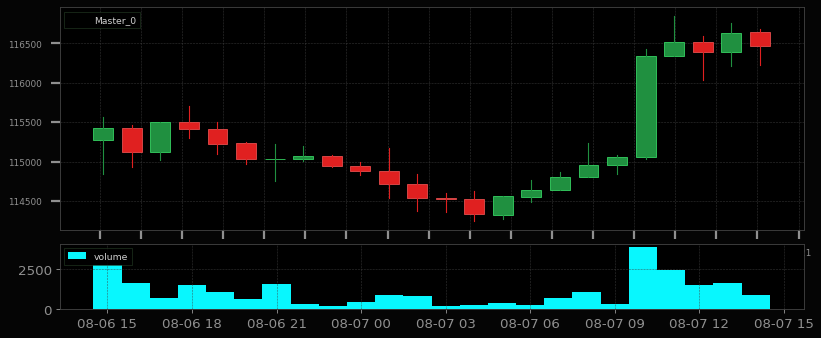

In [6]:
ohlc = ctx.ohlc(ctx.query_instrument("BTCUSDC")).pd()

LookingGlass(
    ohlc,
    {
        "volume": ["bars", ohlc["volume"]],
    },
    backend="mpl",
).look()

## 3.0 Plot the orderbook

In [7]:
symbol = "BTCUSDC"
instrument = ctx.query_instrument(symbol)
ob = ctx.get_data(instrument, DataType.ORDERBOOK[0.0, 20])[-1]
ob

[2025-08-07T14:19:30.304000000] 116474.0 (32.96439) | 116475.0 (0.00232)

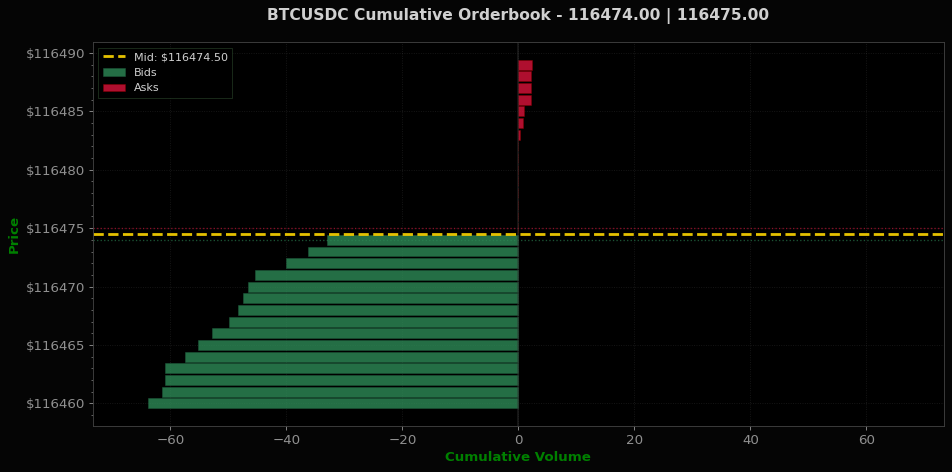

In [8]:
import matplotlib.pyplot as plt
from qubx.utils.charting.orderbook import plot_orderbook, plot_orderbook_depth, plot_orderbook_comparison

# Plot regular orderbook
# fig1, ax1 = plot_orderbook(ob, cumulative=False, max_levels=15, 
#                           title=f"BTCUSDC Orderbook - {ob.top_bid:.2f} | {ob.top_ask:.2f}")
# plt.show()

# Plot cumulative orderbook  
fig2, ax2 = plot_orderbook(ob, cumulative=True, max_levels=15,
                          title=f"BTCUSDC Cumulative Orderbook - {ob.top_bid:.2f} | {ob.top_ask:.2f}",
                          figsize=(12, 6))
plt.show()

# Plot depth chart
# fig3, ax3 = plot_orderbook_depth(ob, max_levels=15,
#                                 title=f"BTCUSDC Depth Chart - {ob.top_bid:.2f} | {ob.top_ask:.2f}")
# plt.show()

## 4.0 Orderbook Time Evolution Comparison

Let's compare how the orderbook has evolved over the last 10 snapshots.

In [9]:
obs = ctx.get_data(instrument, DataType.ORDERBOOK[0.0, 20])[-10:]
len(obs)

10

Comparing 5 orderbook snapshots
Actual timestamps: ['14:19:30.304', '14:19:31.437', '14:19:32.513', '14:19:33.666', '14:19:34.673']
Labels: ['T-5s', 'T-3s', 'T-2s', 'T-1s', 'Now']


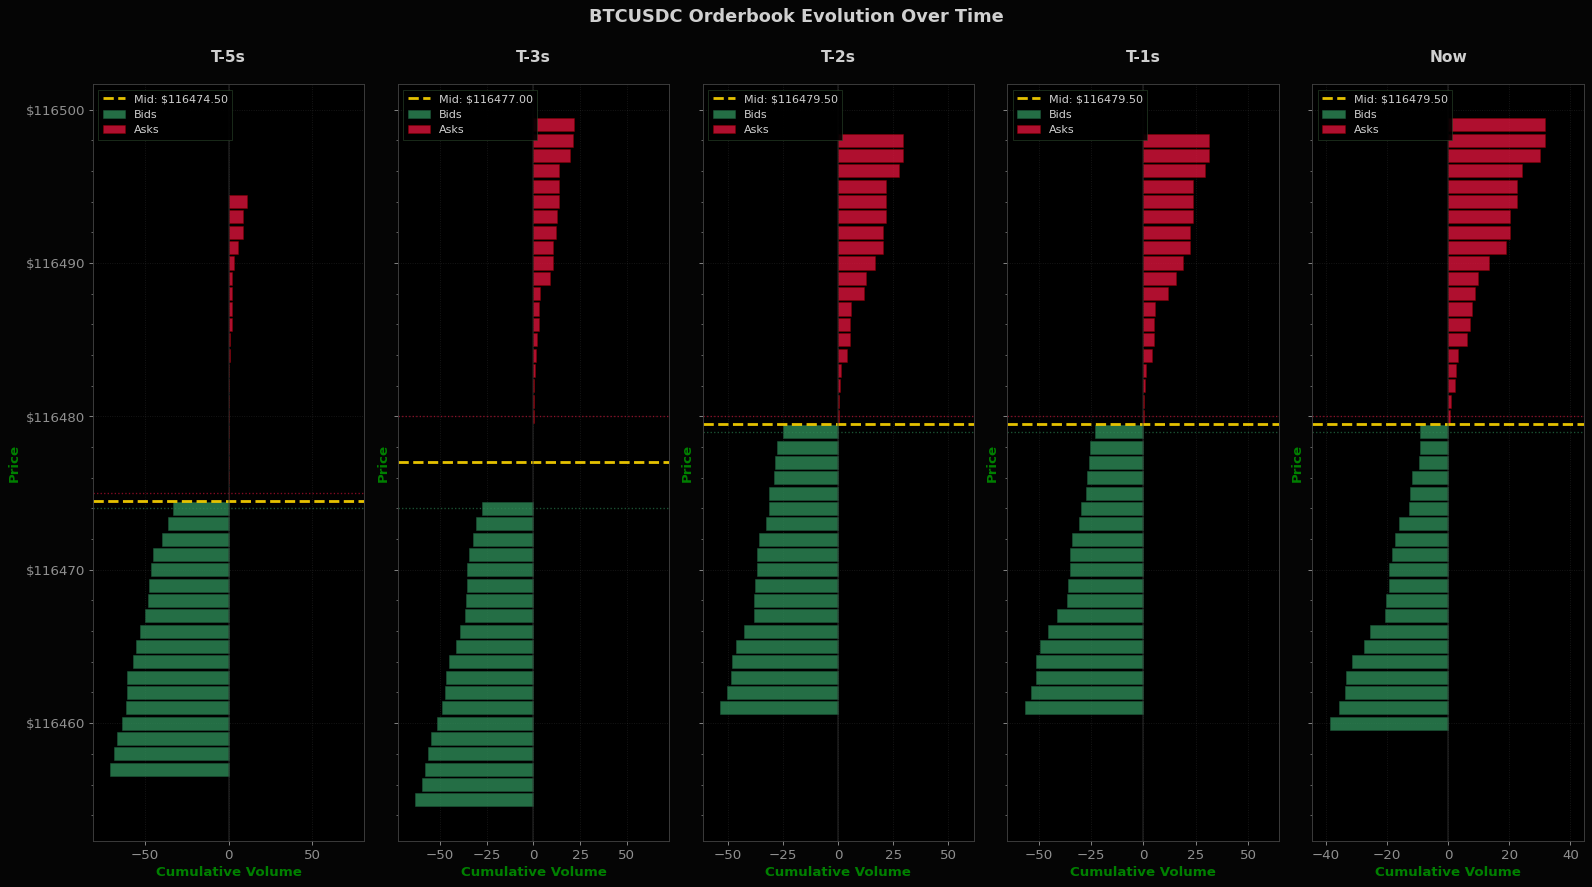

In [10]:
# Compare the evolution of orderbooks over time
# Let's take every 2nd orderbook to avoid overcrowding (5 total)
comparison_obs = obs[::2]  # Take every 2nd orderbook

# Create proper time labels using actual timestamps
timestamps = [pd.Timestamp(ob.time) for ob in comparison_obs]
current_time = pd.Timestamp(obs[-1].time)
labels = []

for ts in timestamps:
    seconds_ago = int((current_time - ts).total_seconds())
    if seconds_ago == 0:
        labels.append("Now")
    elif seconds_ago < 60:
        labels.append(f"T-{seconds_ago}s")
    else:
        minutes_ago = seconds_ago // 60
        labels.append(f"T-{minutes_ago}m{seconds_ago % 60}s")

print(f"Comparing {len(comparison_obs)} orderbook snapshots")
print("Actual timestamps:", [ts.strftime("%H:%M:%S.%f")[:-3] for ts in timestamps])
print("Labels:", labels)

# Create comparison plot
fig, axes = plot_orderbook_comparison(comparison_obs, labels=labels, 
                                    cumulative=True, figsize=(20, 12))
plt.suptitle('BTCUSDC Orderbook Evolution Over Time', fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 5.0 Plot current fundings

This requires to have the instrument lookup table setup either as file or in db.

In [11]:
instruments = lookup.find_instruments("HYPERLIQUID.F")
len(instruments)

201

In [12]:
symbol_to_fr = {}

for i in instruments:
    frs = ctx.get_data(i, DataType.FUNDING_RATE)
    if frs:
        symbol_to_fr[i.symbol] = frs[-1].rate

frs = pd.DataFrame.from_dict(
    symbol_to_fr, orient="index", columns=["fr"]
).mul(24 * 365 * 100).squeeze().sort_values(ascending=False)

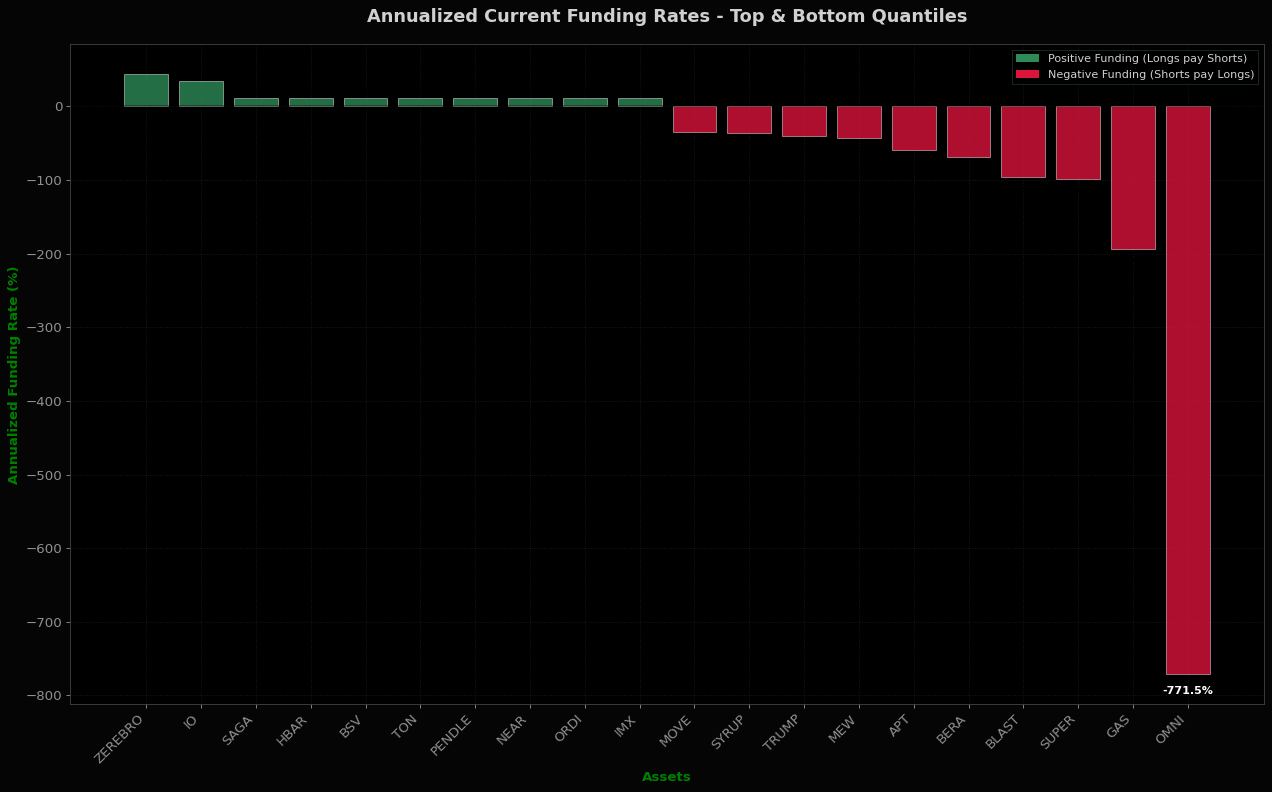

In [13]:
# Plot top and bottom quantiles of funding rates using the new utility
from qubx.utils.charting.mpl_helpers import plot_quantiles

fig, ax = plot_quantiles(
    frs, 
    top_n=10, 
    bottom_n=10,
    title='Annualized Current Funding Rates - Top & Bottom Quantiles',
    ylabel='Annualized Funding Rate (%)',
    xlabel='Assets',
    value_formatter=lambda x: f'{x:.1f}%',
    label_transformer=lambda x: x.replace('USDC', ''),
    positive_label='Positive Funding (Longs pay Shorts)',
    negative_label='Negative Funding (Shorts pay Longs)'
)
plt.show()

How does OMNI funding rate look historically in the last week?

In [17]:
hist_fp = cast(
    pd.DataFrame,
    ctx.get_aux_data(DataType.FUNDING_PAYMENT, exchange="HYPERLIQUID.F", symbols=["OMNIUSDC"])
)
hist_fp["funding_rate_apr"] = hist_fp["funding_rate"] * 24 * 365 * 100

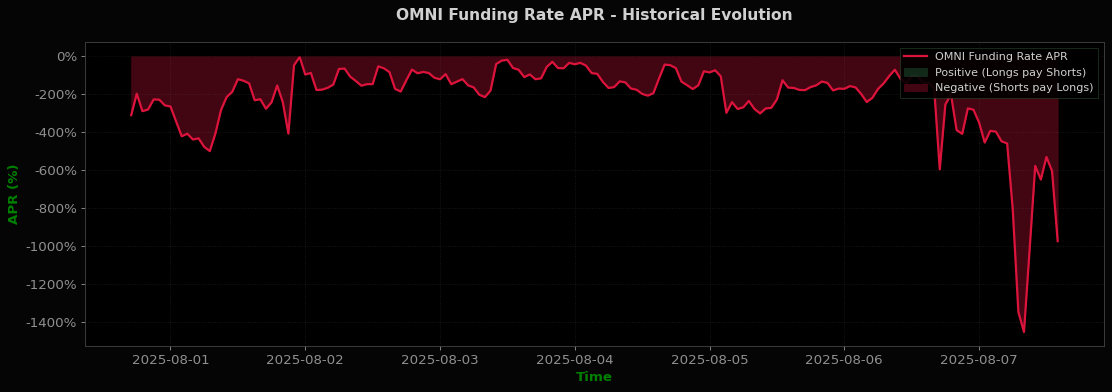

In [18]:
# Plot with fill to zero
fig, ax = plt.subplots(figsize=(14, 5))

funding_series = hist_fp["funding_rate_apr"].droplevel("symbol")

# Plot the line
ax.plot(funding_series.index, funding_series.values, 
        color='#DC143C', linewidth=2, label='OMNI Funding Rate APR')

# Fill to zero with different colors for positive/negative
ax.fill_between(funding_series.index, funding_series.values, 0, 
                where=(funding_series.values >= 0), 
                color='#2E8B57', alpha=0.3, interpolate=True, label='Positive (Longs pay Shorts)')
ax.fill_between(funding_series.index, funding_series.values, 0, 
                where=(funding_series.values < 0), 
                color='#DC143C', alpha=0.3, interpolate=True, label='Negative (Shorts pay Longs)')

# Add horizontal line at zero
ax.axhline(y=0, color='black', linestyle='-', alpha=0.4, linewidth=1.5)

# Customize the plot
ax.set_title('OMNI Funding Rate APR - Historical Evolution', fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('APR (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.25, linestyle=':', linewidth=0.8, color='#666666')
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)

# Format y-axis to show percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))

plt.tight_layout()
plt.show()

In [ ]:
ctx.add_instruments([ctx.query_instrument("OMNIUSDC")])

Stop context

In [91]:
ctx.stop()